In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

from pmdarima import auto_arima

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [2]:
from pmo_forcasting.data.handler import DataHandler

In [3]:
df = DataHandler.from_registry(
    "DATA", "processed_dir", "processed_prices_data.csv").load()



In [4]:

tsla = (
    df[df["ticker"] == "TSLA"]
    .sort_values("date")
    .set_index("date")
)

tsla.head()

,open,high,low,close,adj_close,volume,ticker,asset_class,risk_profile,daily_return,rolling_vol
date,,,,,,,,,,,
2015-01-02 00:00:00+00:00,14.858000,14.883333,14.217333,14.620667,14.620667,71466000,TSLA,equity,high,NaN,NaN
2015-01-05 00:00:00+00:00,14.303333,14.433333,13.810667,14.006000,14.006000,80527500,TSLA,equity,high,-0.042041,NaN
2015-01-06 00:00:00+00:00,14.004000,14.280000,13.614000,14.085333,14.085333,93928500,TSLA,equity,high,0.005664,NaN
2015-01-07 00:00:00+00:00,14.223333,14.318667,13.985333,14.063333,14.063333,44526000,TSLA,equity,high,-0.001562,NaN
2015-01-08 00:00:00+00:00,14.187333,14.253333,14.000667,14.041333,14.041333,51637500,TSLA,equity,high,-0.001564,NaN


In [5]:
y = tsla["close"]

In [6]:
train = y.loc[: "2024-12-31"]
test = y.loc["2025-01-01":]

len(train), len(test)

(2515, 8)

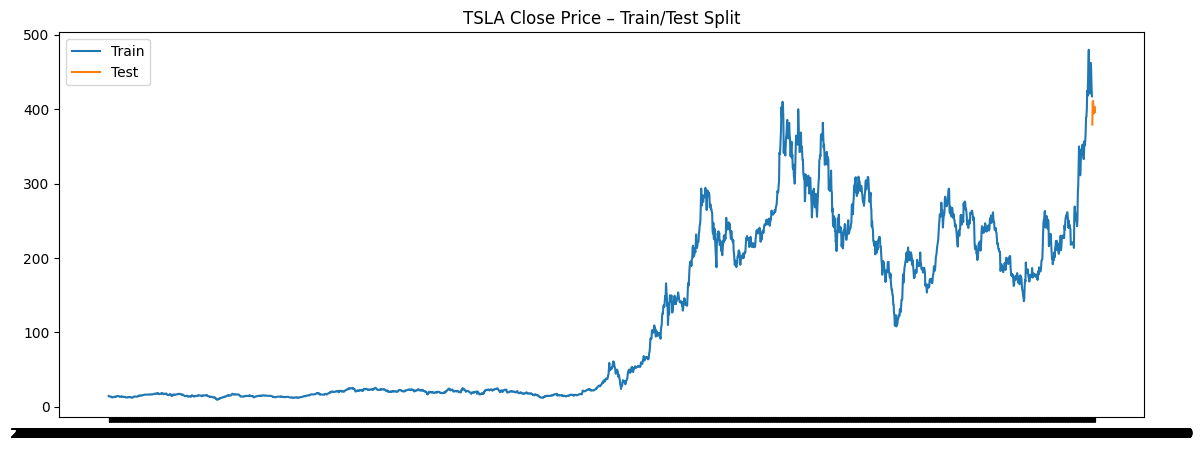

In [7]:
plt.figure(figsize=(14, 5))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.title("TSLA Close Price – Train/Test Split")
plt.legend()
plt.show()

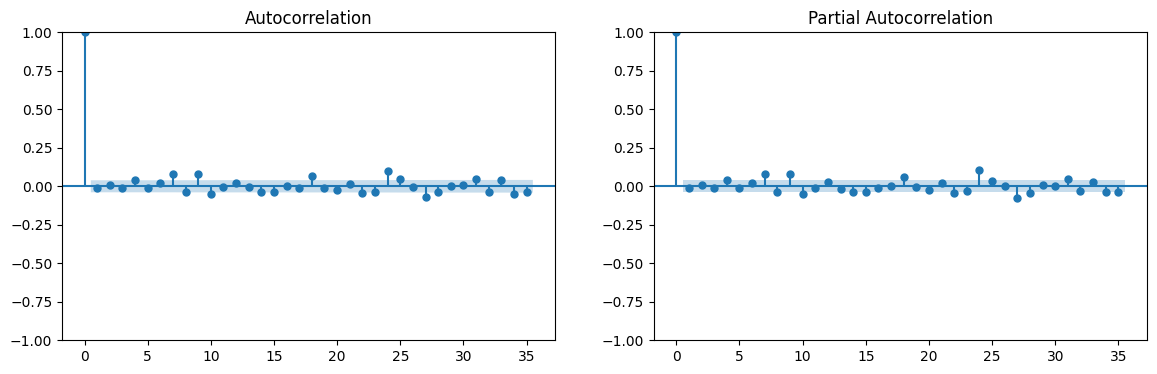

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(train.diff().dropna(), ax=axes[0])
plot_pacf(train.diff().dropna(), ax=axes[1])

plt.show()

In [9]:
auto_model = auto_arima(
    train,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    trace=True
)

auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16364.706, Time=3.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16358.257, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16360.063, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16360.065, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16357.905, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16362.064, Time=0.46 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 5.229 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2515
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -8177.952
Date:                Sun, 25 Jan 2026   AIC                          16357.905
Time:                        12:52:01   BIC                          16363.735
Sample:                             0   HQIC                         16360.021
                               - 2515                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        39.1761      0.440     88.970      0.000      38.313      40.039
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):             11768.47
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):             535.58   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
arima = ARIMA(
    train,
    order=auto_model.order
).fit()

arima.summary()

d:\10Acadamy\Week 9\Tasks\Portfolio-Management-Optimization\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\10Acadamy\Week 9\Tasks\Portfolio-Management-Optimization\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\10Acadamy\Week 9\Tasks\Portfolio-Management-Optimization\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 2515
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -8177.952
Date:                Sun, 25 Jan 2026   AIC                          16357.905
Time:                        12:53:01   BIC                          16363.735
Sample:                             0   HQIC                         16360.021
                               - 2515                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        39.1761      0.440     88.970      0.000      38.313      40.039
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):             11768.47
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):             535.58   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
arima_forecast = arima.forecast(steps=len(test))
arima_forecast.index = test.index

d:\10Acadamy\Week 9\Tasks\Portfolio-Management-Optimization\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\10Acadamy\Week 9\Tasks\Portfolio-Management-Optimization\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [12]:
arima_mae = mean_absolute_error(test, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
arima_mape = np.mean(np.abs((test - arima_forecast) / test)) * 100

arima_mae, arima_rmse, arima_mape

(19.35000991821287,
 np.float64(21.607218822704148),
 np.float64(4.9228772896100566))

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(y.values.reshape(-1, 1))

In [14]:
def create_sequences(data, window=60):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [15]:
window = 60

train_scaled = scaled[: len(train)]
test_scaled = scaled[len(train) - window:]

X_train, y_train = create_sequences(train_scaled, window)
X_test, y_test = create_sequences(test_scaled, window)

X_train.shape, X_test.shape

((2455, 60, 1), (9, 60, 1))

In [16]:
lstm_model = Sequential([
    LSTM(64, input_shape=(window, 1), return_sequences=False),
    Dense(1)
])

lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse"
)

lstm_model.summary()

d:\10Acadamy\Week 9\Tasks\Portfolio-Management-Optimization\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = lstm_model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - loss: 0.0048 - val_loss: 0.0024
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 6.2448e-04 - val_loss: 0.0019
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 5.8887e-04 - val_loss: 0.0029
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 6.0366e-04 - val_loss: 0.0016
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 4.6644e-04 - val_loss: 0.0015
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 5.0983e-04 - val_loss: 0.0018
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 4.1362e-04 - val_loss: 0.0013
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 3.8660e-04 - val_loss: 0.0013
Epoch 9/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 3.8786e-04 - val_loss: 0.0013
Epoch 10/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 3.6497e-04 - val_loss: 0.0010
Epoch 11/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 3.3574e-04 - val_loss: 9.8832e-04
Epoch 12/20
70/70 

In [18]:
lstm_preds = lstm_model.predict(X_test)
lstm_preds = scaler.inverse_transform(lstm_preds).ravel()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


In [20]:
# Align actual values with predictions
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

lstm_mae = mean_absolute_error(y_test_actual, lstm_preds)
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_preds))
lstm_mape = np.mean(np.abs((y_test_actual - lstm_preds) / y_test_actual)) * 100

lstm_mae, lstm_rmse, lstm_mape

(13.27313232421877,
 np.float64(16.786692109999205),
 np.float64(3.3391557993558614))

In [21]:
comparison = pd.DataFrame({
    "MAE": [arima_mae, lstm_mae],
    "RMSE": [arima_rmse, lstm_rmse],
    "MAPE (%)": [arima_mape, lstm_mape]
}, index=["ARIMA", "LSTM"])

comparison

,MAE,RMSE,MAPE (%)
ARIMA,19.350010,21.607219,4.922877
LSTM,13.273132,16.786692,3.339156
